In [58]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy

from tqdm import tqdm
from molecule_featurizer import MoleculeFeaturizer
from collections import defaultdict
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcEnrichment, CalcAUC, CalcROC
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from numpy.random import default_rng

In [59]:
rng = default_rng()

In [60]:
t = pd.read_csv('results/scaffold_split_0_new_platinum')

In [61]:
t.head(1)

,Unnamed: 0,all_targets,all_preds,all_losses,mean_loss,all_bioactive_rank,median_bioactive_rank,bioactive_accuracy,n_bioactive,n_generated,generated_accuracy,ccdc_accuracy,n_heavy_atoms,n_rotatable_bonds,ef20_pred,ef20_ccdc
0,COc1ccc(-c2cn(C)c(=O)c3cc(C(=O)NC4CCS(=O)(=O)C...,"[0.0, 0.0, 0.0, 1.5365843, 1.2933521, 1.101103...","[0.37155512, 0.9122846, 0.37217087, 0.85298246...","[0.13805320858955383, 0.8322632312774658, 0.13...",0.38573,[ 4 62 5],5.0,0.0,3.0,100.0,False,False,32.0,5.0,1.0,3.0


1

In [62]:
data_dir = 'data/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]
    
with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)

In [63]:
encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

In [78]:
active_ratio = 0.1
regression_table = pd.DataFrame(columns=['split', 'average_type', 'rmse_all', 'rmse_gen', 'rmse_bio', 'r2_all', 'r2_gen', 'pearson_all', 'pearson_gen'])
bioactive_accuracy_table = pd.DataFrame(columns=['split', 'top1_acc', 'topn_acc', 'q1', 'med', 'q3'])
ranking_table = pd.DataFrame(columns=['split', 'ranker', 'ef20', 'bedroc'])

rankers = ['ccdc', 'energy', 'random', 'model']
splits = ['random', 'scaffold']
iterations = range(5)
bedrocs = defaultdict(dict)
efs = defaultdict(dict)
for ranker in rankers :
    bedrocs[ranker] = defaultdict(dict)
    efs[ranker] = defaultdict(dict)
    for split in splits :
        bedrocs[ranker][split] = defaultdict(list)
        efs[ranker][split] = defaultdict(list)

for split in splits :

    for iteration in iterations :
        
        t = pd.read_csv(f'results/{split}_split_{iteration}_new_platinum')
        t = t[(t['n_generated'] < 100) & (t['Unnamed: 0'] != 'Micro') & (t['n_generated'] > 1)]

        top1_accuracies = []
        bioactive_ranks = []
        all_targets = []
        all_preds = []
        all_generated_targets = []
        all_generated_energies = []
        all_generated_preds = []
        all_generated_activities = []
        all_bioactive_preds = []
        n_rotatable_bonds = []
        relative_ranks_model = []
        relative_ranks_ccdc = []
        relative_ranks_random = []
        r2s_all = []
        r2s_gen = []
        pearsons_all = []
        pearsons_gen = []
        spearmans_all = []
        spearmans_gen = []
        rmses_all = []
        rmses_gen = []
        rmses_bio = []
        for mol_i in tqdm(range(len(t) - 1)) :

            smiles = t.iloc[mol_i, 0]
            ce = cel.get_conf_ensemble(smiles)
            rdkit_mol = ce.mol
            data_list = mol_featurizer.featurize_mol(rdkit_mol)
            energies = [data.energy for data in data_list]
            energies = np.array(energies)
            
            targets = json.loads(t.iloc[mol_i, 1])
            targets = np.array(targets)
            generated = targets != 0
            generated_targets = targets[generated]
            generated_energies = energies[generated]
            
            preds = json.loads(t.iloc[mol_i, 2])
            preds = np.array(preds)
            
            all_targets.extend(targets)
            all_preds.extend(preds)

            r2s_all.append(r2_score(targets, preds))
            pearsons_all.append(pearsonr(targets, preds)[0])
            spearmans_all.append(spearmanr(targets, preds)[0])
            rmses_all.append(mean_squared_error(targets, preds, squared=False))

            is_bioactive = targets == 0
            pred_ranks = preds.argsort().argsort()
            bioactive_pred_ranks = pred_ranks[is_bioactive]
            bioactive_ranks.extend(bioactive_pred_ranks.tolist())

            top1_accuracies.append(0 in bioactive_pred_ranks)

            generated_preds = preds[generated]
            all_generated_targets.extend(generated_targets)
            all_generated_energies.extend(generated_energies)
            all_generated_preds.extend(generated_preds)

            r2s_gen.append(r2_score(generated_targets, generated_preds))
            pearsons_gen.append(pearsonr(generated_targets, generated_preds)[0])
            spearmans_gen.append(spearmanr(generated_targets, generated_preds)[0])
            rmses_gen.append(mean_squared_error(generated_targets, generated_preds, squared=False))
            
            bioactive_preds = preds[~generated]
            all_bioactive_preds.extend(bioactive_preds)
            rmses_bio.append(np.mean(bioactive_preds))

            actives_i = np.argsort(generated_targets)[:int(len(generated_targets) * active_ratio)]
            activity = [True if i in actives_i else False for i in range(len(generated_preds))]
            all_generated_activities.extend(activity)
            preds_array = np.array(list(zip(generated_preds, activity)))

            relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
            ranks_ccdc = np.array(range(len(generated_preds)))
            relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
            np.random.shuffle(generated_preds)
            relative_ranks_random.extend(generated_preds.argsort().argsort() / len(generated_preds))

            ranked_lists = {}
            
            ranked_lists['ccdc'] = preds_array
            
            # Prediction ranking
            sorting = np.argsort(preds_array[:, 0])
            sorted_preds_array = preds_array[sorting]
            ranked_lists['model'] = sorted_preds_array
            
            # Energy ranking
            preds_array = np.array(list(zip(generated_energies, activity)))
            sorting = np.argsort(preds_array[:, 0])
            sorted_preds_array = preds_array[sorting]
            ranked_lists['energy'] = sorted_preds_array

            # Random ranking
            random_preds_array = copy.deepcopy(preds_array)
            rng.shuffle(random_preds_array)
            ranked_lists['random'] = random_preds_array

            for ranker in rankers :
                efs[ranker][split][iteration].append(CalcEnrichment(ranked_lists[ranker], col=1, fractions=[0.2])[0])
                bedrocs[ranker][split][iteration].append(CalcBEDROC(ranked_lists[ranker], col=1, alpha=20))
            
            n_rotatable_bonds.append(int(t.iloc[mol_i, 13]))

        q1, med, q3 = np.quantile(bioactive_ranks, [0.25, 0.5, 0.75])

        new_row = pd.Series({'split' : split,
                              'top1_acc' : np.mean(top1_accuracies),
                              'topn_acc' : np.mean(t['bioactive_accuracy']),
                              'q1' : q1,
                              'med' : med,
                              'q3' : q3})
        bioactive_accuracy_table = bioactive_accuracy_table.append(new_row, ignore_index=True)

        for ranker in rankers :
        
            new_row = pd.Series({'split' : split,
                                  'ranker' : ranker,
                                  'ef20' : np.mean(efs[ranker][split][iteration]),
                                  'bedroc' : np.mean(bedrocs[ranker][split][iteration])})
            ranking_table = ranking_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'macro',
                              'rmse_all' : np.mean(rmses_all),
                              'rmse_gen' : np.mean(rmses_gen),
                             'rmse_bio' : np.mean(rmses_bio),
                              'r2_all' : np.mean(r2s_all),
                              'r2_gen' : np.mean(r2s_gen),
                                'pearson_all' : np.mean(pearsons_all),
                            'pearson_gen' : np.mean(pearsons_gen),
                            'spearman_all' : np.mean(spearmans_all),
                            'spearman_gen' : np.mean(spearmans_gen)})
        regression_table = regression_table.append(new_row, ignore_index=True)
        
        new_row = pd.Series({'split' : split,
                             'average_type' : 'micro',
                              'rmse_all' : mean_squared_error(all_targets, all_preds, squared=False),
                              'rmse_gen' : mean_squared_error(all_generated_targets, all_generated_preds, squared=False),
                              'rmse_bio' : np.mean(all_bioactive_preds),
                              'r2_all' : r2_score(all_targets, all_preds),
                              'r2_gen' : r2_score(all_generated_targets, all_generated_preds),
                            'pearson_all' : pearsonr(all_targets, all_preds)[0],
                            'pearson_gen' : pearsonr(all_generated_targets, all_generated_preds)[0],
                            'spearman_all' : spearmanr(all_targets, all_preds)[0],
                            'spearman_gen' : spearmanr(all_generated_targets, all_generated_preds)[0]})
        regression_table = regression_table.append(new_row, ignore_index=True)

 40%|███████████████▊                        | 644/1624 [00:36<00:55, 17.81it/s]RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [18:10:03] UFFTYPER: Unrecognized charge state for atom: 11
[18:10:03] UFFTYPER: Unrecognized charge state fo

In [79]:
regression_table

,split,average_type,rmse_all,rmse_gen,rmse_bio,r2_all,r2_gen,pearson_all,pearson_gen,spearman_all,spearman_gen
0,random,macro,0.456874,0.422776,0.682872,-1.024884,-86.106092,0.358306,0.311927,0.320130,0.298245
1,random,micro,0.525089,0.503089,0.694094,0.299567,0.264876,0.601735,0.590284,0.570782,0.555138
2,random,macro,0.433893,0.411008,0.602191,-0.709717,-27.790523,0.369537,0.322083,0.338095,0.307988
3,random,micro,0.497666,0.480927,0.612224,0.370817,0.328217,0.637814,0.630390,0.596335,0.582501
4,random,macro,0.478190,0.408928,0.897494,-1.399207,-1158.723898,0.274419,0.294521,0.255204,0.282477
5,random,micro,0.521226,0.485119,0.893635,0.309834,0.316453,0.599775,0.608493,0.567759,0.568874
6,random,macro,0.471076,0.404065,0.882613,-1.227271,-603.884317,0.289218,0.293188,0.276509,0.286290
7,random,micro,0.517724,0.481577,0.876915,0.319077,0.326398,0.601333,0.611515,0.573006,0.574671
8,random,macro,0.468277,0.407101,0.853066,-1.334685,-201.563012,0.288527,0.300405,0.281479,0.293929
9,random,micro,0.506614,0.471196,0.856901,0.347988,0.355126,0.612643,0.626218,0.571064,0.576015


<AxesSubplot:ylabel='Count'>

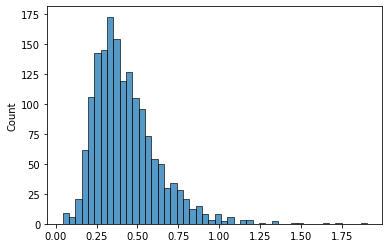

In [80]:
sns.histplot(rmses_gen)

<AxesSubplot:ylabel='Count'>

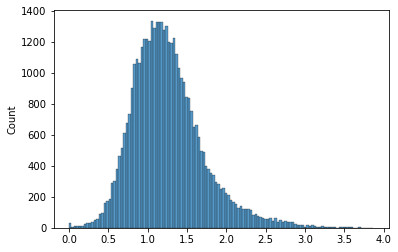

In [81]:
sns.histplot(all_generated_preds)

<AxesSubplot:ylabel='Count'>

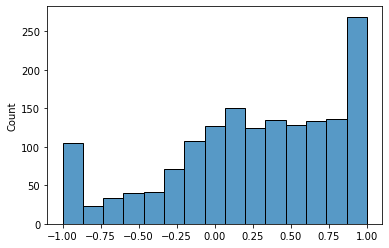

In [82]:
sns.histplot(pearsons_gen)

<AxesSubplot:ylabel='Count'>

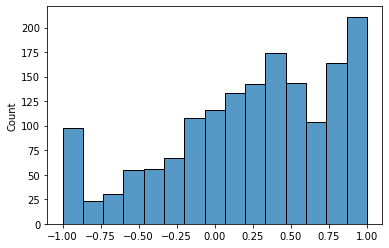

In [83]:
sns.histplot(spearmans_gen)

In [84]:
np.mean(all_generated_targets)

1.1875529768721753

In [85]:
np.std(all_generated_targets)

0.5867652858837343

<AxesSubplot:ylabel='Count'>

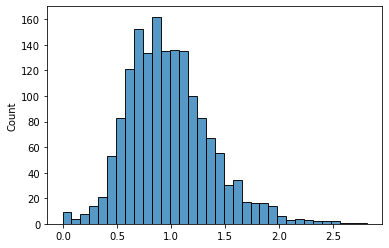

In [86]:
sns.histplot(rmses_bio)

In [87]:
bioactive_accuracy_table

,split,top1_acc,topn_acc,q1,med,q3
0,random,0.340517,0.347339,0.0,2.0,7.0
1,random,0.370074,0.373185,0.0,2.0,7.0
2,random,0.165025,0.173544,2.0,4.0,12.0
3,random,0.181650,0.194186,1.0,4.0,11.0
4,random,0.190271,0.193336,1.0,4.0,11.0
5,scaffold,0.257389,0.263673,1.0,3.0,9.0
6,scaffold,0.274631,0.282264,1.0,3.0,9.0
7,scaffold,0.179187,0.184156,2.0,4.0,12.0
8,scaffold,0.171182,0.179980,1.0,4.0,12.0
9,scaffold,0.179187,0.183130,2.0,4.0,12.0


In [88]:
ranking_table

,split,ranker,ef20,bedroc
0,random,ccdc,1.203700,0.165467
1,random,energy,1.005381,0.122948
2,random,random,0.611728,0.060177
3,random,model,1.308093,0.170766
4,random,ccdc,1.203700,0.165467
5,random,energy,1.005381,0.122948
6,random,random,0.617985,0.066748
7,random,model,1.303375,0.170357
8,random,ccdc,1.203700,0.165467
9,random,energy,1.005381,0.122948


<AxesSubplot:xlabel='ranker', ylabel='ef20'>

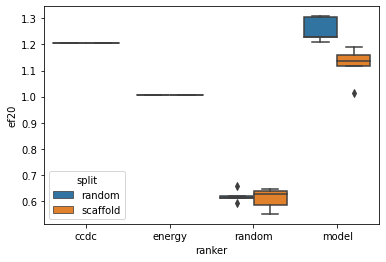

In [89]:
sns.boxplot(data=ranking_table, x='ranker', y='ef20', hue='split')

<AxesSubplot:xlabel='ranker', ylabel='bedroc'>

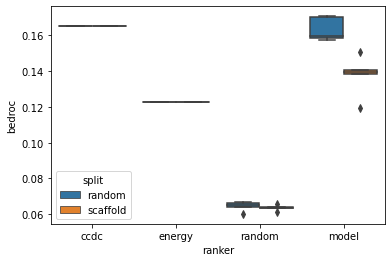

In [90]:
sns.boxplot(data=ranking_table, x='ranker', y='bedroc', hue='split')

<AxesSubplot:xlabel='ranker', ylabel='bedroc'>

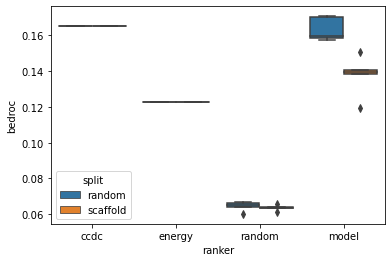

In [91]:
sns.boxplot(data=ranking_table, x='ranker', y='bedroc', hue='split')

<AxesSubplot:ylabel='Count'>

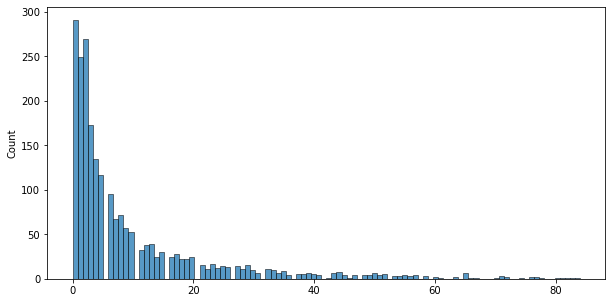

In [92]:
plt.figure(figsize=(10, 5))
sns.histplot(bioactive_ranks, bins=100)

The issue is that we can't rank conformations with CCDC from different molecules.
In practice, we would rank conformations for the same molecule.

In [24]:
thresholds = [n for n in np.arange(0, 1, 0.01)]
retrieved_ccdc = []
retrieved_model = []
retrieved_random = []
relative_ranks_ccdc = np.array(relative_ranks_ccdc)
relative_ranks_model = np.array(relative_ranks_model)
relative_ranks_random = np.array(relative_ranks_random)
all_generated_activities = np.array(all_generated_activities)
n_actives = all_generated_activities.sum()
for threshold in tqdm(thresholds) :
    ccdc_below_threshold = relative_ranks_ccdc < threshold
    retrieved_ccdc.append((all_generated_activities * ccdc_below_threshold).sum() / n_actives)
    model_below_threshold = relative_ranks_model < threshold
    retrieved_model.append((all_generated_activities * model_below_threshold).sum() / n_actives)
    random_below_threshold = relative_ranks_random < threshold
    retrieved_random.append((all_generated_activities * random_below_threshold).sum() / n_actives)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2080.01it/s]


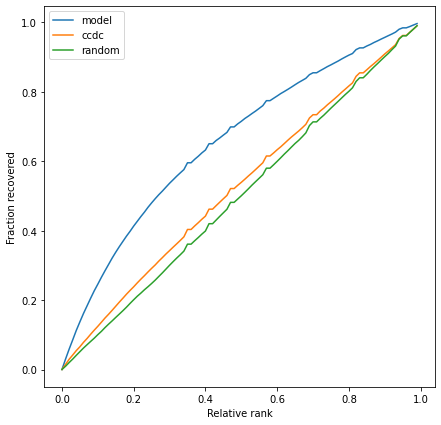

In [25]:
plt.figure(figsize=(7,7))
plt.plot(thresholds, retrieved_model, label='model')
plt.plot(thresholds, retrieved_ccdc, label='ccdc')
plt.plot(thresholds, retrieved_random, label='random')
plt.xlabel('Relative rank')
plt.ylabel('Fraction recovered')
plt.legend()

In [26]:
preds_array = np.array(list(zip(all_preds, all_generated_activities)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

<AxesSubplot:ylabel='Count'>

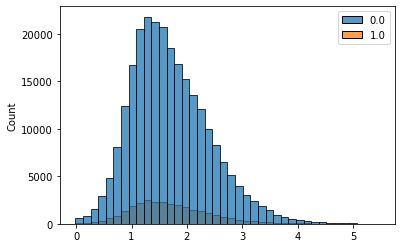

In [27]:
sns.histplot(x=preds_array[:,0], hue=preds_array[:,1], bins=40)

<AxesSubplot:>

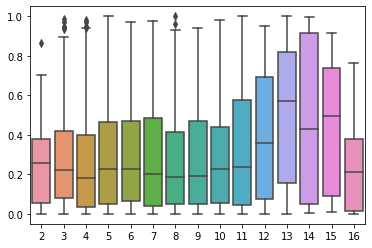

In [28]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_model)

<AxesSubplot:>

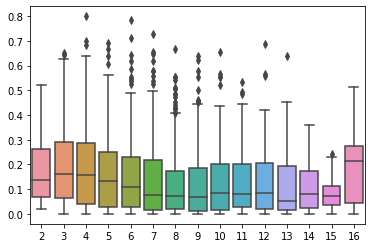

In [29]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_ccdc)

<AxesSubplot:>

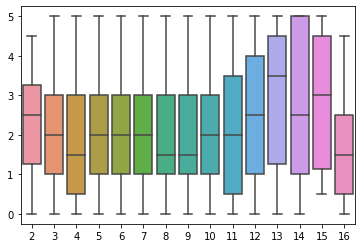

In [30]:
sns.boxplot(x=n_rotatable_bonds, y=ef_model)

<AxesSubplot:>

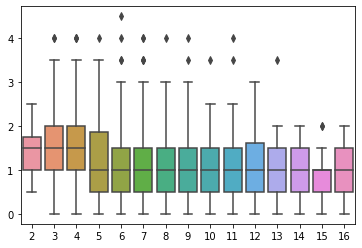

In [31]:
sns.boxplot(x=n_rotatable_bonds, y=ef_ccdc)

In [32]:
t_nomicro = t.dropna(subset=['n_heavy_atoms']).copy()
t_nomicro['n_heavy_atoms'] = t_nomicro['n_heavy_atoms'].astype(int)
t_nomicro['n_rotatable_bonds'] = t_nomicro['n_rotatable_bonds'].astype(int)

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_rotatable_bonds'>

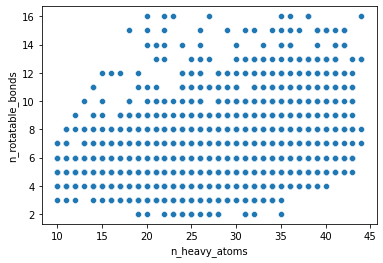

In [33]:
#plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_heavy_atoms', y='n_rotatable_bonds')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='n_bioactive'>

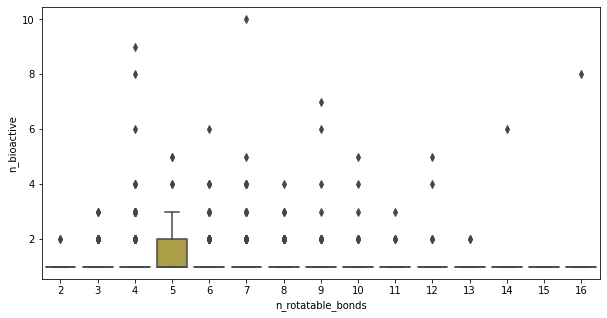

In [34]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='n_bioactive')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='mean_loss'>

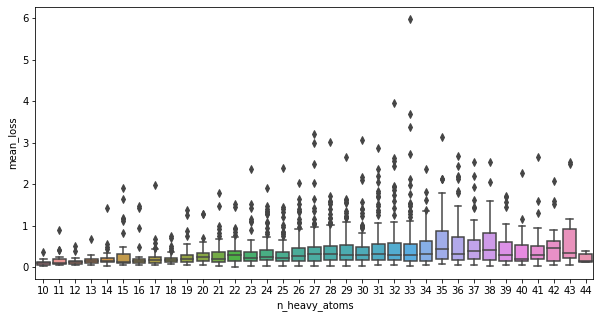

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='mean_loss')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='mean_loss'>

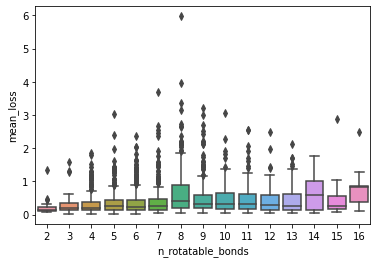

In [36]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='mean_loss')

<AxesSubplot:xlabel='n_generated', ylabel='Count'>

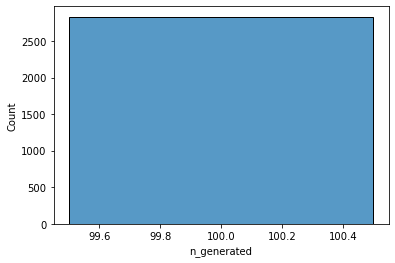

In [37]:
sns.histplot(data=t_nomicro, x='n_generated')

<AxesSubplot:xlabel='n_generated', ylabel='mean_loss'>

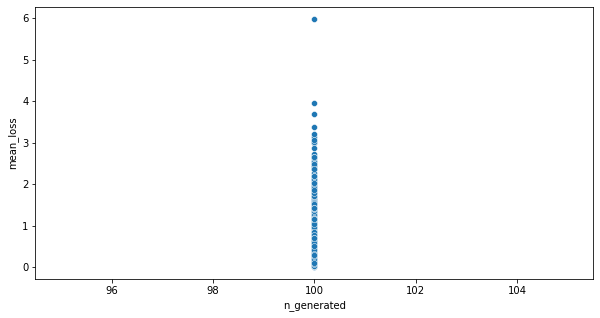

In [38]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_generated', y='mean_loss')

<AxesSubplot:xlabel='n_bioactive', ylabel='median_bioactive_rank'>

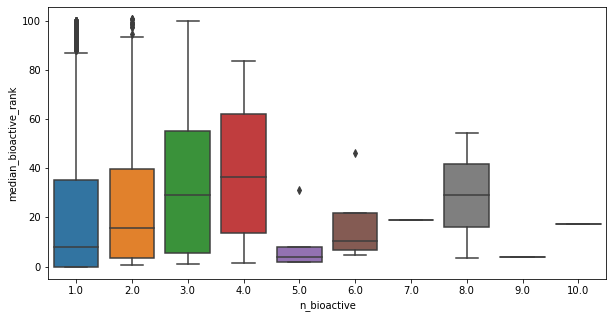

In [39]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_bioactive', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='median_bioactive_rank'>

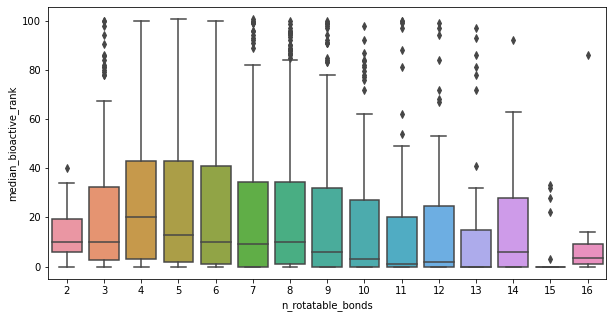

In [40]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='bioactive_accuracy'>

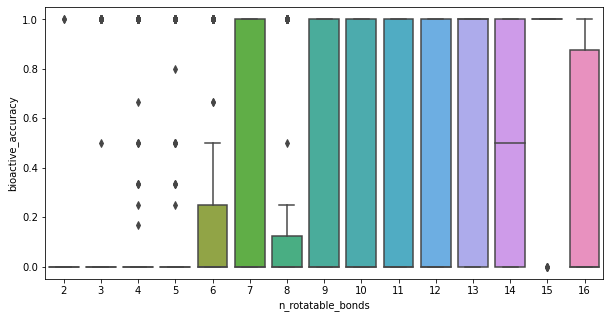

In [41]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='bioactive_accuracy')